In [2]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
import os
import sys
import glob
import collections
import pandas as pd
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from transformers import BertConfig, BertModel

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import tokenizers
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, LineByLineTextDataset, BertModel, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

SAVING_FRAMES_PER_SECOND = 30

In [3]:
BEH_LABELS = ['drink', 'eat', 'groom', 'hang', 'sniff', 'rear', 'rest', 'walk', 'nibble']
action_colours = ['tab:blue', 'tab:orange', 'limegreen', 'deepskyblue', 'tab:pink', 'tab:purple', 'tab:brown', 'red', 'black']
len(action_colours) == len(BEH_LABELS)

True

In [4]:
VIDEO_FOLDER = "/cifs/data/tserre/CLPS_Serre_Lab/nih/files_to_send/"
ACTION_FOLDER = "/cifs/data/tserre/CLPS_Serre_Lab/nih/inference/results_csv/"

In [5]:
time_counter = {
    'under5':0,
    '5-10':0,
    '10-15':0,
    '15-20':0,
    '20-25':0,
    '25-30':0,
    '30-35':0,
    '35-40':0,
    '40-45':0,
    '45-50':0,
    '50-55':0,
    '55-60':0,
    '60-90':0,
    '90-450':0,
    '450-1800':0,
    '1800-4500':0,
    'over4500':0,}

In [6]:
def get_repeat_vocab(repeat_number):
    # > '0-5'
    # > '5-15'
    # > '15-45'
    # > '45-90'
    # > '90-450'
    # > '450-1800'
    # > '1800-4500'
    # > 'over4500'
    if repeat_number > 0 and repeat_number <= 5:
        box = "under5"
    elif repeat_number > 5 and repeat_number <= 10:
        box = "5-10"
    elif repeat_number > 10 and repeat_number <= 15:
        box = "10-15"
    elif repeat_number > 15 and repeat_number <= 20:
        box = "15-20"
    elif repeat_number > 20 and repeat_number <= 25:
        box = "20-25"
    elif repeat_number > 25 and repeat_number <= 30:
        box = "25-30"
    elif repeat_number > 30 and repeat_number <= 35:
        box = "30-35"
    elif repeat_number > 35 and repeat_number <= 40:
        box = "35-40"
    elif repeat_number > 40 and repeat_number <= 45:
        box = "40-45"
    elif repeat_number > 45 and repeat_number <= 50:
        box = "45-50"
    elif repeat_number > 50 and repeat_number <= 55:
        box = "50-55"
    elif repeat_number > 55 and repeat_number <= 60:
        box = "55-60"
    elif repeat_number > 60 and repeat_number <= 90:
        box = "60-90"
    elif repeat_number > 90 and repeat_number <= 450:
        box = "90-450"
    elif repeat_number > 450 and repeat_number <= 1800:
        box = "450-1800"
    elif repeat_number > 1800 and repeat_number <= 4500:
        box = "1800-4500"
    elif repeat_number > 4500:
        box = "over4500"
    else:
        raise ValueError('A very specific bad thing happened.')
    time_counter[box] += 1
    return box

In [7]:
def cleaning_actions(action_list):
    WINDOW_SIZE = 3 # Each side
    
    index = WINDOW_SIZE
    action_length = len(action_list)
    
    while index < (action_length - WINDOW_SIZE - 1):
        current_action = action_list[index]
        window = action_list[index - WINDOW_SIZE : index + WINDOW_SIZE + 1]
        window_elements = collections.Counter(window)
        most_common_action = window_elements.most_common(1)[0][0]
        if action_list[index] != most_common_action:
            action_list[index] = most_common_action
        index += 1
    return action_list

In [8]:
def generate_language_from_labels(action_list, class_label):
    SENTENCE_LENGTH = 900 # in terms of frames
    
    start_index = 0
    action_length = len(action_list)
    
    language = []
#     label = []
    sentence = ""
    
    current_sentence_length = 0
    while start_index < action_length:
        
        current_action = action_list[start_index]
        current_action_label = BEH_LABELS[current_action]
        
        next_action_idx = start_index + 1
        
        while next_action_idx < action_length and current_action == action_list[next_action_idx]:
            next_action_idx  += 1
        repeats = next_action_idx - start_index
        
        if current_sentence_length == 0:
            sentence = ""
            
        current_sentence_length += repeats
        start_index = next_action_idx
        
        sentence += str(current_action_label)+" "+get_repeat_vocab(repeats)+" "
        
        if current_sentence_length >= SENTENCE_LENGTH:
            language.append(sentence)
#             label.append(class_label)
            current_sentence_length = 0
            
    if sentence != "":
        language.append(sentence)
#         label.append(class_label)
    return language

In [9]:
all_preexposure_actions_17202338_c = np.load("all_preexposure_actions_17202338_c.npy")
all_postcond_actions_17202338_c = np.load("all_postcond_actions_17202338_c.npy")

In [10]:
raw_text = []
labels = []

In [11]:
cleaned_preexposure_c = cleaning_actions(all_preexposure_actions_17202338_c)
print("Preexposure done.")
cleaned_postcond_c = cleaning_actions(all_postcond_actions_17202338_c)
print("Postcond done.")

Preexposure done.
Postcond done.


In [12]:
preexposure_c = generate_language_from_labels(cleaned_preexposure_c, 0)
preexp_time_counter_c = time_counter
raw_text += preexposure_c
labels += [0]*len(preexposure_c)

postcond_c = generate_language_from_labels(cleaned_postcond_c, 1)
postcond_time_counter_c = time_counter
raw_text += postcond_c
labels += [1]*len(postcond_c)

print("Number of Sequences:", len(raw_text));
print("Number of Labels:", len(labels))

Number of Sequences: 4577
Number of Labels: 4577


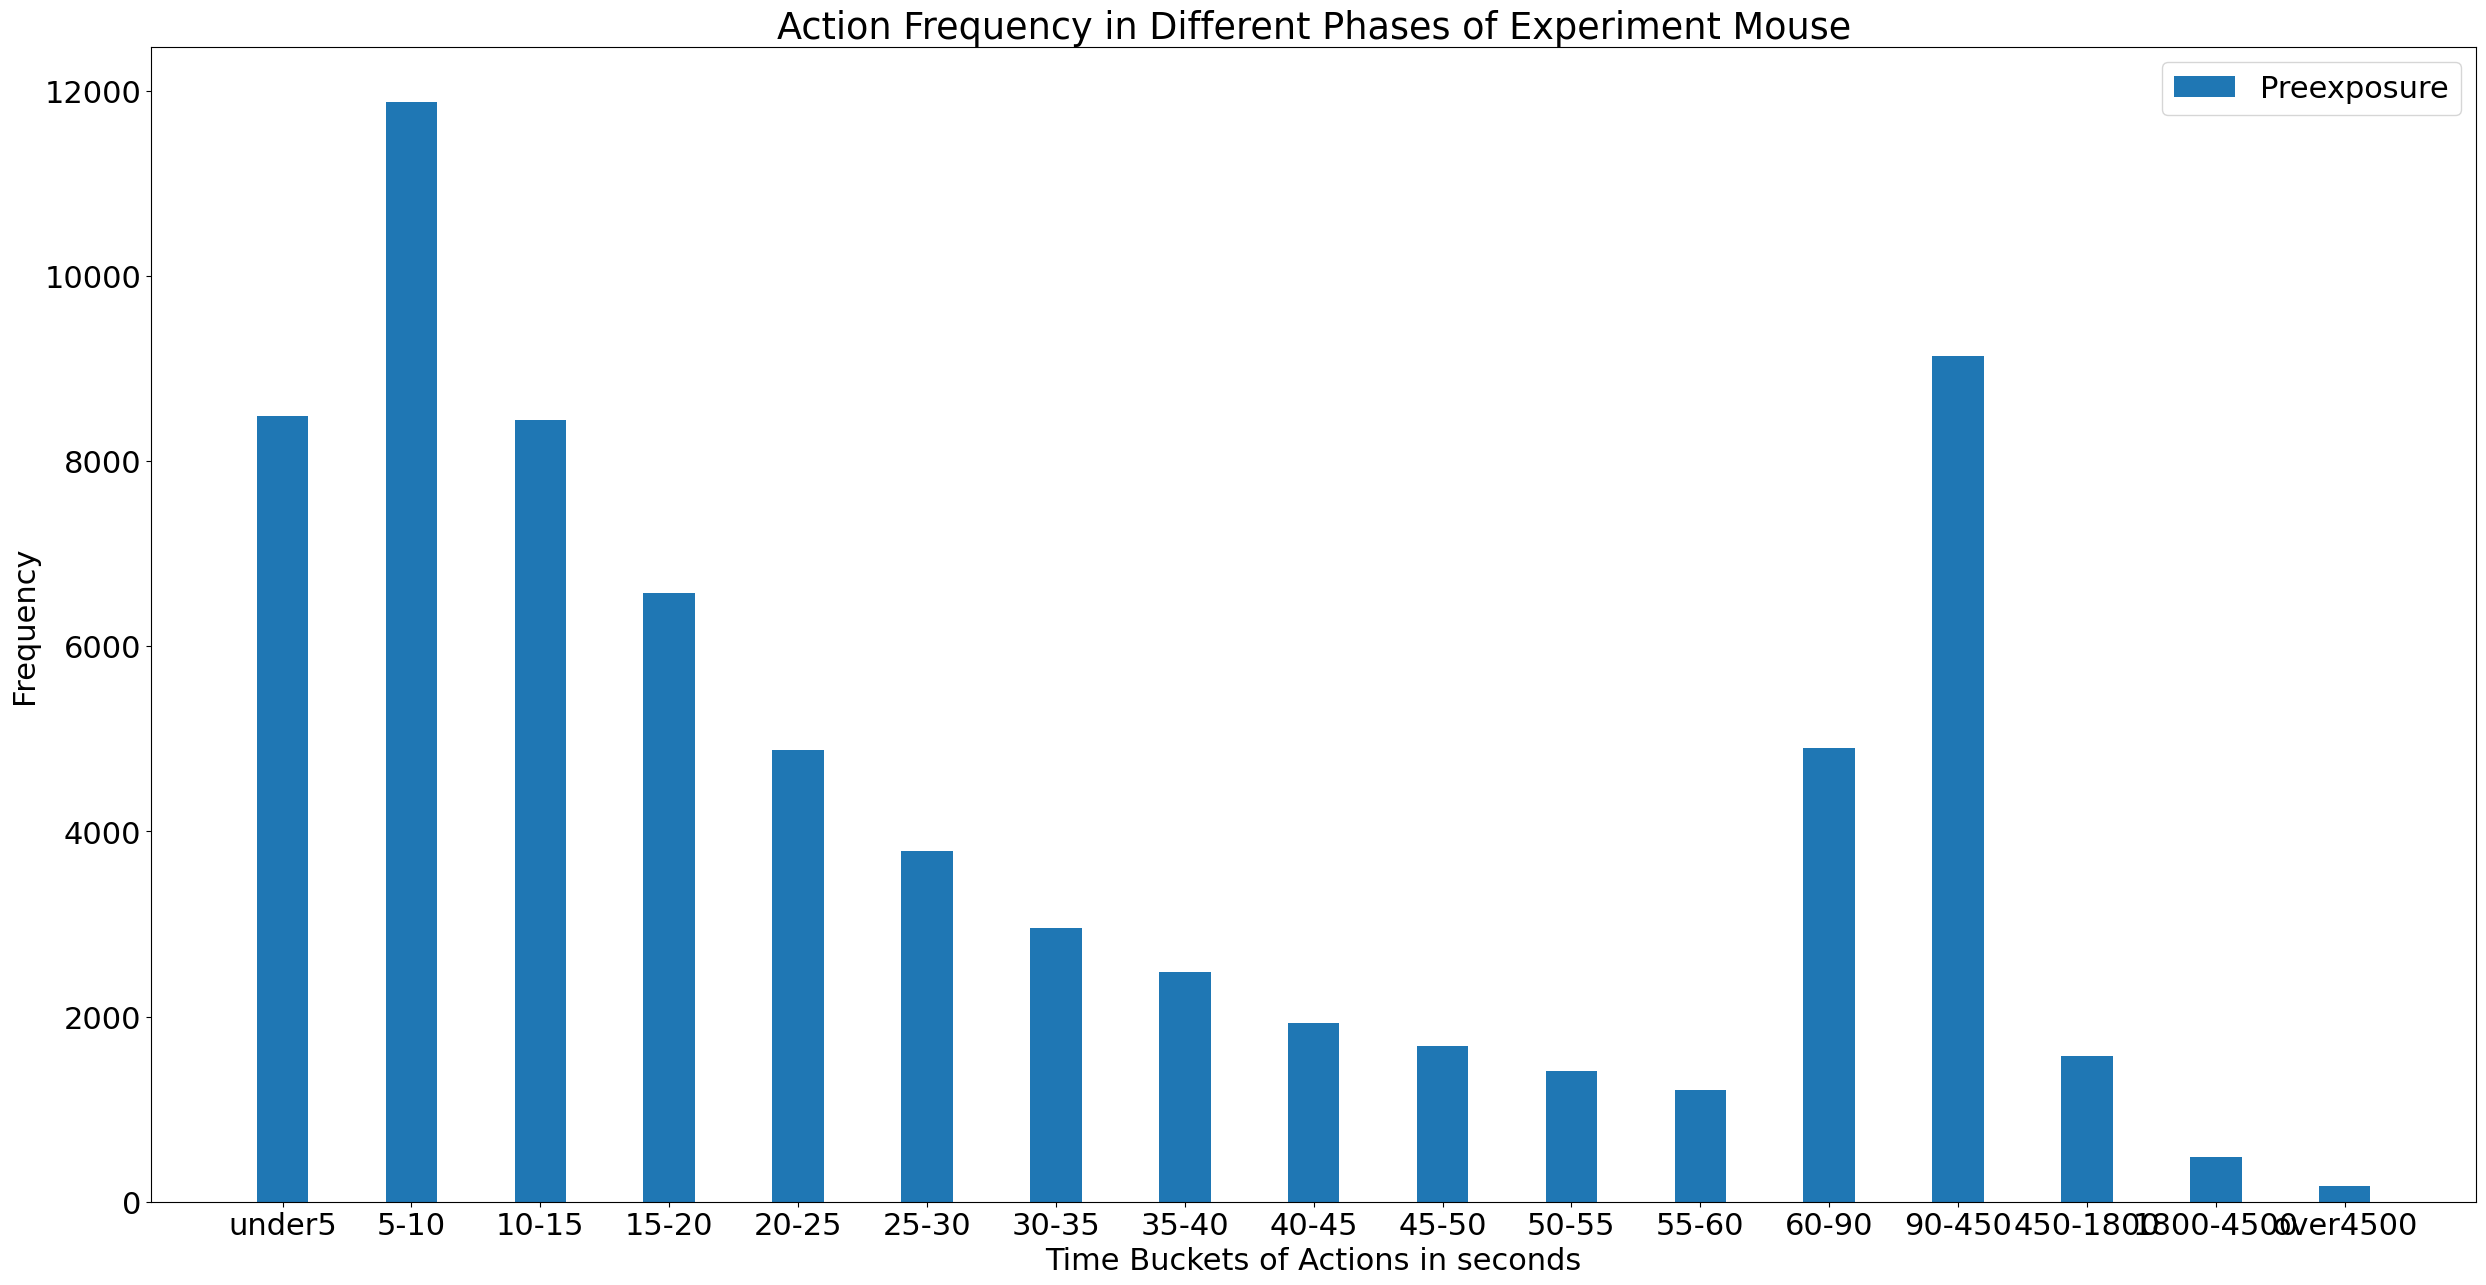

In [13]:
# Plot time distributions:
times = [time_counter[x] for x in time_counter.keys()]

X = [x for x in time_counter.keys()]
X_axis = np.arange(len(X))

plt.figure(figsize=(30, 15))
plt.rcParams.update({'font.size': 22})
plt.bar(X_axis , times, 0.4, label = 'Preexposure')

plt.xticks(X_axis, X)
plt.xlabel("Time Buckets of Actions in seconds")
plt.ylabel("Frequency")
plt.title("Action Frequency in Different Phases of Experiment Mouse")
plt.legend()
plt.show()

In [14]:
from tqdm import tqdm
from transformers import BertTokenizer

# create a python generator to dynamically load the data
def batch_iterator(batch_size=100):
    for i in tqdm(range(0, len(raw_text), batch_size)):
        print("Batch:", raw_text[i : i + batch_size])
        yield raw_datasets[i : i + batch_size]

tokenizer = BertTokenizer("nih_vocab.txt", do_basic_tokenize=False)

In [15]:
example_text = 'sniff 20-25 groom under5 sniff 5-10 groom 10-15 sniff 40-45 groom 20-25 sniff 5-10 groom 20-25 sniff under5 groom 50-55 sniff 90-450 groom 20-25 sniff 60-90 groom 90-450 sniff 15-20 groom 30-35 sniff 55-60 groom 60-90 sniff 60-90 nibble 10-15 sniff 15-20 nibble 45-50 sniff 50-55'
bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")
print(bert_input)

{'input_ids': tensor([[ 2, 26,  9, 24,  5, 26,  6, 24,  7, 26, 13, 24,  9, 26,  6, 24,  9, 26,
          5, 24, 15, 26, 18, 24,  9, 26, 17, 24, 18, 26,  8, 24, 11, 26, 16, 24,
         17, 26, 17, 30,  7, 26,  8, 30, 14, 26, 15,  3,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  

In [16]:
def print_rand_sentence():
    '''
    Displays the tokens and respective IDs of a random text sample
    '''
    index = random.randint(0, len(raw_text)-1)
    table = np.array([tokenizer.tokenize(raw_text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(raw_text[index]))]).T
    print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ groom    │          24 │
├──────────┼─────────────┤
│ 10-15    │           7 │
├──────────┼─────────────┤
│ sniff    │          26 │
├──────────┼─────────────┤
│ 450-1800 │          19 │
╘══════════╧═════════════╛


In [17]:
# Checking max sequence length and vocabulary
max_seq_len = 0
seq_lens = []
overall_set = set()
for seq in preexposure_c:
    overall_set.update(seq.split())
    seq_lens.append(len(seq))
    if len(seq) > max_seq_len:
        max_seq_len = len(seq)
print("Maximum sequence length:", max_seq_len)
seq_lens = np.array(seq_lens)
print("Average:", np.mean(seq_lens))
print("Standard Deviation:", np.std(seq_lens))
print("Final Vocabulary:", overall_set)
print("Length of Vocabulary:", len(overall_set))

Maximum sequence length: 995
Average: 184.27982261640798
Standard Deviation: 116.50905664468583
Final Vocabulary: {'drink', '40-45', '30-35', '5-10', '55-60', 'over4500', 'rear', '90-450', '50-55', '25-30', '15-20', '35-40', 'hang', '1800-4500', 'under5', '450-1800', 'groom', 'sniff', '60-90', 'walk', '20-25', 'rest', '10-15', 'nibble', 'eat', '45-50'}
Length of Vocabulary: 26


In [ ]:
class Mouse_Action_Sequence_Dataset(torch.utils.data.Dataset):
    def __init__(self, raw_text, tokenizer):
        super(Mouse_Action_Sequence_Dataset, self).__init__()
        self.sequence_list = raw_text
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.sequence_list)

    def __getitem__(self, idx):
        sequence = self.sequence_list[idx]
        tokenized_sequence = self.tokenizer.tokenize(sequence)
        sequence_ids = tokenizer.convert_tokens_to_ids(tokenized_sequence)
        tensor_sequence = torch.tensor(sequence_ids)
        return {'input_ids': tensor_sequence}

In [18]:
dataset= LineByLineTextDataset(
    tokenizer = tokenizer,
    file_path = 'a.txt',
    block_size = 128
)

/gpfs/data/tserre/anagara8/pytorch/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:121: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
dataset[0]

In [ ]:
dataset = Mouse_Action_Sequence_Dataset(raw_text, tokenizer)

In [ ]:
dataset[0]

In [19]:
config = BertConfig(
    vocab_size=31,
    hidden_size=128, 
    num_hidden_layers=12, 
    num_attention_heads=16,
    max_position_embeddings=512
)

In [20]:
model = BertForMaskedLM(config)
print('No of parameters: ', model.num_parameters())

No of parameters:  10361119


In [21]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [23]:
training_args = TrainingArguments(
    output_dir='mlm_on_32_hours_LBL',
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_steps=10_000,
    save_total_limit=2,
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

In [ ]:
trainer.train()

/gpfs/data/tserre/anagara8/pytorch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10
  Number of trainable parameters = 10361119
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grassknoted (serrelab). Use `wandb login --relogin` to force relogin


/gpfs/data/tserre/anagara8/pytorch/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
